In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import itertools
from tensorflow.keras.models import load_model
import os
import cv2
from PIL import Image, ExifTags

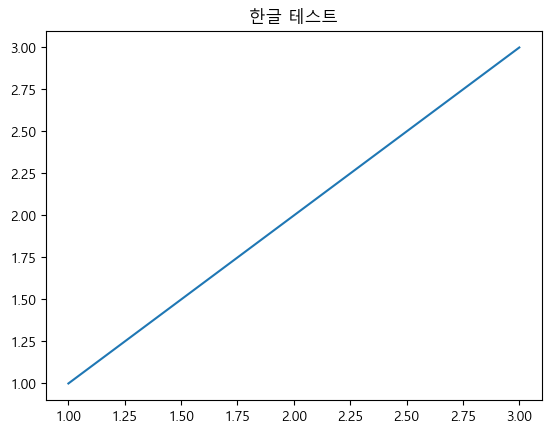

In [2]:
# 한글 폰트 설정 (Windows는 'Malgun Gothic', Mac은 'AppleGothic', Ubuntu는 'NanumGothic' 등)
plt.rc('font', family='Malgun Gothic')  # Windows의 경우

# 한글이 깨지지 않도록 마이너스 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# 테스트 그래프
plt.plot([1, 2, 3], [1, 2, 3])
plt.title("한글 테스트")  # 한글이 깨지지 않는지 확인
plt.show()

In [3]:
# 수정된 데이터 경로 설정
train: "D:/JOLJAK/TOMATO_Train"  # 학습 이미지의 상위 폴더 경로 (하위 폴더들을 자동으로 탐색)
val: "D:/JOLJAK/TOMATO_Val" 


색 분류해서 클래스 만들기

In [4]:
class_labels = [
    'tomato_green',    # Class 1: 녹숙기
    'tomato_breaker',  # Class 2: 변색기
    'tomato_pink',     # Class 3: 채색기
    'tomato_light_red',# Class 4: 도색기
    'tomato_red',      # Class 5: 담적색기
    'tomato_ripe'      # Class 6: 완숙기
]


이미지 로드 및 RGB 값 추출

In [17]:
import cv2
import os
import numpy as np

def calculate_red_ratio(image):
    """
    이미지에서 적색 비율을 계산합니다.
    
    Parameters:
    - image: 이미지 데이터 (numpy 배열)
    
    Returns:
    - 적색 비율 (0.0 ~ 1.0 사이 값)
    """
    if image.size == 0:
        raise ValueError("Empty image area.")
    
    # BGR -> RGB 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 적색 성분(R)이 일정 기준 이상인 픽셀을 '적색'으로 간주 (기준은 R > 150로 설정)
    red_pixels = np.sum(image_rgb[:, :, 0] > 150)  # R 값이 150 이상인 픽셀 수
    total_pixels = image.shape[0] * image.shape[1]  # 전체 픽셀 수
    
    # 적색 비율 계산
    red_ratio = red_pixels / total_pixels
    return red_ratio

def classify_tomato_by_red_ratio(red_ratio):
    """
    적색 비율을 기준으로 토마토의 익음 단계를 분류하고 그에 따른 클래스 번호를 반환합니다.
    
    Parameters:
    - red_ratio: 적색 비율 (0.0 ~ 1.0 사이 값)
    
    Returns:
    - 분류된 클래스 번호 (int)
    """
    if red_ratio <= 0.03:
        return 0  # Class 0: 녹숙기
    elif 0.03 < red_ratio <= 0.10:
        return 1  # Class 1: 변색기
    elif 0.10 < red_ratio <= 0.30:
        return 2  # Class 2: 채색기
    elif 0.30 < red_ratio <= 0.60:
        return 3  # Class 3: 도색기
    elif 0.60 < red_ratio <= 0.90:
        return 4  # Class 4: 담적색기
    elif red_ratio > 0.90:
        return 5  # Class 5: 완숙기
    else:
        return -1  # Unknown Stage

def read_label_file(label_file):
    """
    라벨 파일에서 바운딩 박스 좌표를 읽어옵니다.
    
    Parameters:
    - label_file: 라벨 파일 경로 (.txt 형식)
    
    Returns:
    - 바운딩 박스 좌표 리스트 [(class_index, x_center, y_center, width, height), ...]
    """
    bboxes = []
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            # YOLO 형식: class_index, x_center, y_center, width, height
            class_index, x_center, y_center, width, height = map(float, parts)
            bboxes.append([class_index, x_center, y_center, width, height])
    return bboxes

def extract_bbox_from_image(image, bbox, image_width, image_height):
    """
    바운딩 박스를 사용하여 이미지에서 해당 영역을 추출합니다.
    
    Parameters:
    - image: 원본 이미지
    - bbox: 바운딩 박스 좌표 (YOLO 형식의 비율)
    - image_width: 이미지 너비
    - image_height: 이미지 높이
    
    Returns:
    - 잘라낸 이미지 영역 (numpy 배열)
    """
    x_center, y_center, width, height = bbox[1:]  # class_index는 제외하고 나머지 좌표 사용
    
    # 비율을 실제 이미지 크기로 변환
    x_min = int((x_center - width / 2) * image_width)
    x_max = int((x_center + width / 2) * image_width)
    y_min = int((y_center - height / 2) * image_height)
    y_max = int((y_center + height / 2) * image_height)
    
    # 이미지 경계를 벗어나지 않도록 경계 조정
    x_min = max(0, x_min)
    x_max = min(image_width, x_max)
    y_min = max(0, y_min)
    y_max = min(image_height, y_max)
    
    # 이미지 자르기
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

def update_label_file(label_file, updated_bboxes):
    """
    업데이트된 바운딩 박스 리스트를 라벨 파일에 다시 저장합니다.
    
    Parameters:
    - label_file: 라벨 파일 경로 (.txt 형식)
    - updated_bboxes: 업데이트된 바운딩 박스 리스트 [(class_index, x_center, y_center, width, height), ...]
    """
    with open(label_file, 'w') as f:
        for bbox in updated_bboxes:
            # YOLO 형식에 맞게 클래스 인덱스와 바운딩 박스 좌표 저장
            f.write(f"{int(bbox[0])} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n")

def process_tomato_image(image_path, label_path):
    """
    토마토 이미지를 로드하고, 바운딩 박스 좌표를 이용하여 열매를 추출한 후 적색 비율로 라벨링을 변경합니다.
    
    Parameters:
    - image_path: 이미지 파일 경로
    - label_path: 라벨 파일 경로
    """
    # 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    
    image_height, image_width, _ = image.shape
    
    # 라벨 파일에서 바운딩 박스 좌표 읽기
    bboxes = read_label_file(label_path)
    updated_bboxes = []
    
    for bbox in bboxes:
        # 바운딩 박스를 사용하여 토마토 열매 부분 추출
        tomato_fruit = extract_bbox_from_image(image, bbox, image_width, image_height)
        
        # 잘라낸 영역이 비어있는 경우 패스
        if tomato_fruit.size == 0:
            print(f"Empty bounding box in image: {image_path}")
            continue
        
        try:
            # 열매에서 적색 비율 계산
            red_ratio = calculate_red_ratio(tomato_fruit)
            
            # 적색 비율을 기준으로 새로운 클래스 번호 할당
            new_class_index = classify_tomato_by_red_ratio(red_ratio)
            bbox[0] = new_class_index  # 클래스 인덱스를 새로운 값으로 업데이트
            updated_bboxes.append(bbox)
        
        except ValueError as ve:
            print(f"Error processing {image_path}: {ve}")
    
    # 업데이트된 바운딩 박스를 다시 라벨 파일에 저장
    if updated_bboxes:
        update_label_file(label_path, updated_bboxes)
        print(f"Updated label file: {label_path}")

def process_folder(folder_path):
    """
    폴더 내의 모든 이미지 파일을 처리하고, 적색 비율을 기반으로 라벨 파일의 클래스를 업데이트합니다.
    
    Parameters:
    - folder_path: 이미지 파일들이 위치한 폴더 경로
    """
    valid_extensions = ['.png']  # 모든 이미지가 .png 형식임
    
    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            image_path = os.path.join(folder_path, filename)
            label_path = image_path.replace(".png", ".txt")  # 라벨 파일은 .txt로 가정
            if os.path.exists(label_path):
                process_tomato_image(image_path, label_path)

# 이미지가 있는 폴더 경로
folder_path = "D:/JOLJAK/TOMATO_Val"

# 폴더 내의 모든 이미지 파일에 대해 적색 비율로 라벨 업데이트 실행
process_folder(folder_path)


Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_061_e_14_20220101_27_06094434_40158887.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_061_e_15_20220101_27_05094401_40158887.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_062_e_14_20220101_27_06094518_40158887.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_063_e_13_20220101_27_05095011_40158887.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_064_e_14_20220101_27_05095053_40158887.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_064_e_16_20220101_27_05095156_40158887.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_074_e_14_20220101_27_06102703_38102607.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_075_e_14_20220101_27_05102756_38102607.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_077_e_14_20220101_27_06103507_38102607.txt
Updated label file: D:/JOLJAK/TOMATO_Val\V001_tom1_00_080_e_14_20220101_27_05104333_38102607.txt
Updated label file: D:/JOLJAK/

-클래스 찾기

In [16]:
import os

def find_invalid_class_labels(folder_path):
    """ 라벨 파일에서 클래스 값이 -1인 파일과 대응되는 이미지 파일을 찾고 그 개수를 셉니다.
    
    Parameters:
    - folder_path: 이미지와 라벨 파일이 위치한 폴더 경로
    
    Returns:
    - 클래스 값이 -1인 라벨 파일에 대응하는 이미지 파일 리스트
    - 클래스 값이 -1인 파일의 개수
    """
    invalid_images = []
    valid_extensions = ['.png']  # 이미지 파일 확장자
    
    # 폴더 내의 모든 파일 검색
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            label_file_path = os.path.join(folder_path, filename)
            with open(label_file_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_index = int(parts[0])

                    # 클래스 인덱스가 -1인 경우
                    if class_index == -1:
                        # 해당 라벨 파일과 동일한 이름의 PNG 파일을 찾음
                        image_file = filename.replace('.txt', '.png')
                        image_path = os.path.join(folder_path, image_file)

                        # 해당 PNG 파일이 존재하는지 확인
                        if os.path.exists(image_path):
                            invalid_images.append(image_path)
                        break  # 한 번만 찾으면 충분하므로 다음 파일로 넘어감

    return invalid_images, len(invalid_images)

# 폴더 경로 설정
folder_path = "D:/JOLJAK/TOMATO_Train"

# 클래스 값이 -1인 PNG 파일 목록과 개수 찾기
invalid_images, count_invalid_images = find_invalid_class_labels(folder_path)

if invalid_images:
    print("클래스 값이 -1인 PNG 파일 목록:")
    for image_path in invalid_images:
        print(image_path)
    print(f"\n클래스 값이 -1인 PNG 파일 개수: {count_invalid_images}")
else:
    print("클래스 값이 -1인 PNG 파일이 없습니다.")




클래스 값이 -1인 PNG 파일이 없습니다.


모델 학습은 아나콘다 프롬프트에서 진행

In [25]:
from ultralytics import YOLO
import torch

# GPU 장치 설정 (첫 번째 GPU를 사용하려면 'cuda:0'으로 설정)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# YOLOv8 모델 로드
model = YOLO('C:/Users/win/runs/detect/train12/weights/best.pt')

# 모델 학습에 GPU 사용
model.train(
    data='C:/Users/win/Desktop/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='custom_yolov8',
    workers=1,
    device=device  # 설정한 GPU 장치 사용
)


New https://pypi.org/project/ultralytics/8.3.19 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=C:/Users/win/runs/detect/train12/weights/best.pt, data=C:/Users/win/Desktop/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=1, project=None, name=custom_yolov86, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning D:\JOLJAK\TOMATO_Train.cache... 27299 images, 1 backgrounds, 0 corrupt: 100%|██████████| 27300/27300 [00:00<?, ?it/s]
val: Scanning D:\JOLJAK\TOMATO_Val.cache... 7800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7800/7800 [00:00<?, ?it/s]


Plotting labels to runs\detect\custom_yolov86\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs\detect\custom_yolov86
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1707 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 20344) exited unexpectedly

yolo test

저장된 모델을 불러와서 예측 레이블(Pred)과 실제 레이블(TRUE) 을 비교하여 이미지와 함께 출력


0: 640x640 1 , 1 , 2 s, 3 s, 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


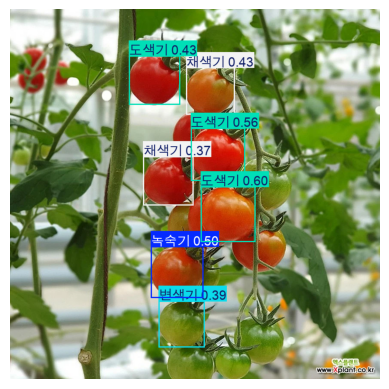


0: 448x640 5 s, 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


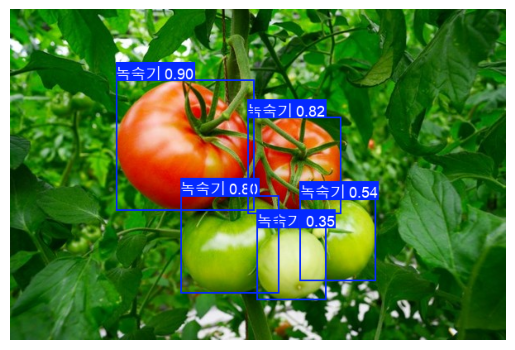


0: 480x640 4 s, 2 s, 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


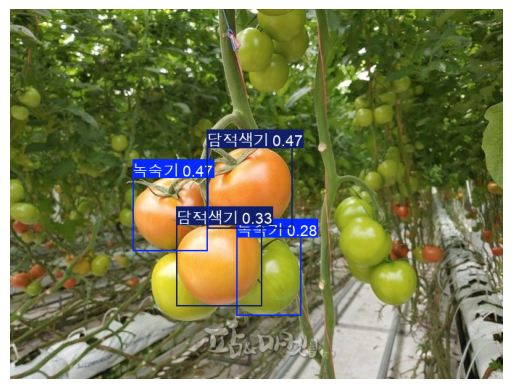


0: 384x640 3 s, 1 , 2 s, 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


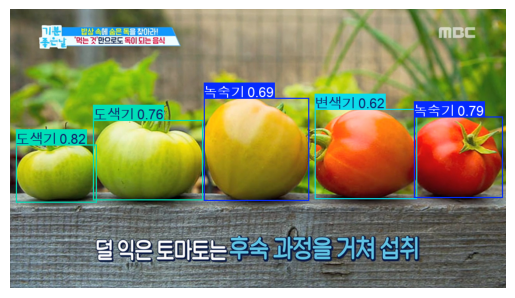


0: 544x640 8 s, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)


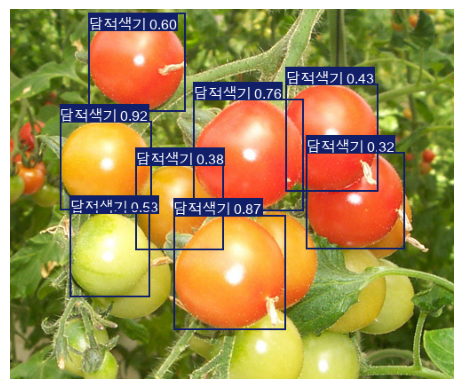


0: 448x640 1 , 7 s, 2 s, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


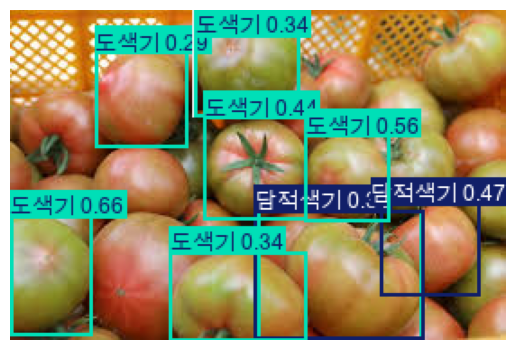


0: 448x640 6 s, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


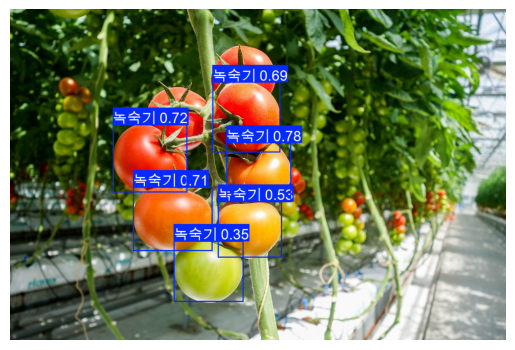


0: 448x640 1 , 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


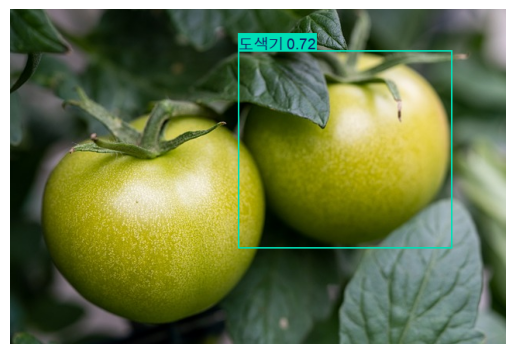


0: 448x640 2 s, 2 s, 1 , 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


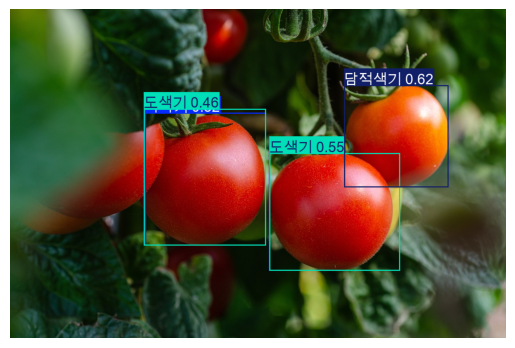


0: 448x640 1 , 3 s, 1 , 31.2ms
Speed: 0.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


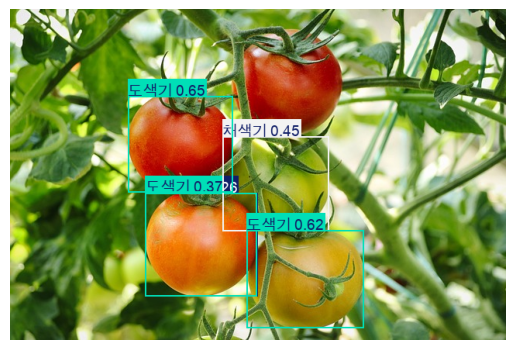


0: 448x640 1 , 3 s, 1 , 25.2ms
Speed: 15.6ms preprocess, 25.2ms inference, 37.4ms postprocess per image at shape (1, 3, 448, 640)


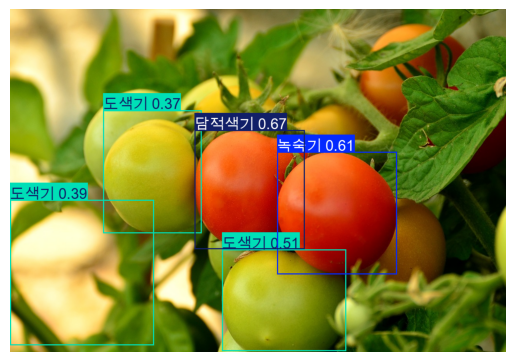


0: 256x640 4 s, 3 s, 2 s, 2 s, 21.8ms
Speed: 15.6ms preprocess, 21.8ms inference, 5.8ms postprocess per image at shape (1, 3, 256, 640)


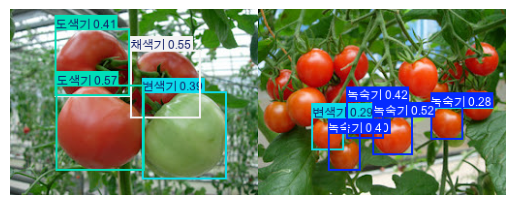


0: 384x640 1 , 4 s, 24.4ms
Speed: 5.0ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


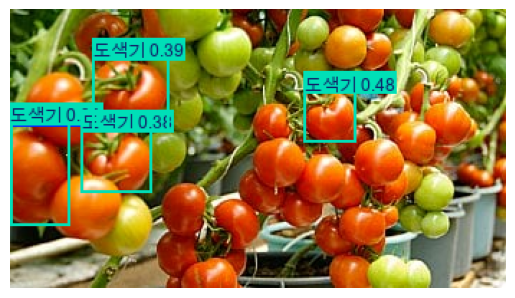

In [7]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

# YOLO 모델 로드
model = YOLO('C:/Users/win/runs/detect/train14/weights/best.pt')

# 테스트 이미지 폴더 경로
test_image_folder = 'D:/JOLJAK/TOMATO_Test'

# 폴더 내 이미지 파일들을 순회하면서 예측 실행
for filename in os.listdir(test_image_folder):
    # 확장자가 JPG, WEBP, JFIF인지 확인
    if filename.lower().endswith(('.jpg', '.webp', '.jfif')):
        image_path = os.path.join(test_image_folder, filename)
        
        # 이미지 불러오기
        img = cv2.imread(image_path)
        
        # YOLO 예측 수행
        results = model.predict(source=img)

        # 예측 결과를 표시할 이미지 생성
        img_with_predictions = results[0].plot()

        # 결과 이미지 출력
        plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
